In [2]:
import idx2numpy
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import random as rand
import cv2
np.set_printoptions(suppress=True)

x_digit = idx2numpy.convert_from_file('data/train-images-idx3-ubyte')
y_digit = idx2numpy.convert_from_file('data/train-labels-idx1-ubyte')

print(x_digit.shape, y_digit.shape)
BATCH_SIZE = 16
TRAIN_SIZE = 50000
TEST_SIZE = 10000
EPOCHS = 10
OUTER_IMG_SZ = 28

(60000, 28, 28) (60000,)


In [3]:
### Generate train and test data using mnist set with GRID_SIDE digits
GRID_SIDE = 1

image_dict = [[] for i in range(10)]
for digit,image in zip(y_digit, x_digit):
    image_dict[digit].append(image)

In [4]:
class TestImgGenSequence(keras.utils.Sequence):
    
    def __init__(self, length_of_set, batch_size=BATCH_SIZE):
        self.batch_size = batch_size
        self.length_of_set = length_of_set
        self.epoch_count = 0.0
    
    def __len__(self):
        'Denotes the number of batches per epoch 10k/128'
        ret = self.length_of_set // self.batch_size
        #print("Returning length as " + str(ret))
        return ret

    def __getitem__(self, index):
        'Generate one batch of data'
        x, y = self.gen_test_data(self.batch_size)
        #print("Shapes of returned ", x.shape, y.shape)
        return x,y
    
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.epoch_count += 1.0
        #print("An epoch ended >>>>>>> xxxxxxx >>>>>> qqq >>>>")
    
    def gen_test_data(self, num_data):
        x_data, y_data = np.zeros((num_data, OUTER_IMG_SZ , OUTER_IMG_SZ)), np.zeros((num_data, GRID_SIDE **2))
        for i in range(num_data):
            #pick a random size so that the grid is at least 70% of the overall image
            border_sz = 0
            digit_sz = rand.randint(OUTER_IMG_SZ//(1.4 * GRID_SIDE), OUTER_IMG_SZ//GRID_SIDE) - 2 * border_sz
            border_digit_sz  = digit_sz + 2 * border_sz
            grid_size = GRID_SIDE * (border_digit_sz)
            #pick random offsets so image doesn't go off screen
            x_offset = rand.randint(0, OUTER_IMG_SZ - grid_size)
            y_offset = rand.randint(0, OUTER_IMG_SZ - grid_size)
            for k in range(GRID_SIDE**2):
                rand_digit = rand.randint(0,9)
                rand_img = rand.choice(image_dict[rand_digit])
                rand_img = cv2.resize(rand_img, (digit_sz, digit_sz))
                if rand_digit == 0 : rand_img = np.zeros((digit_sz, digit_sz))
                rand_img = cv2.copyMakeBorder(rand_img, border_sz,border_sz,border_sz,border_sz, cv2.BORDER_CONSTANT, value = [255,255,255])
                y_data[i,k] = rand_digit
                r = k//GRID_SIDE
                c = k % GRID_SIDE
                x_data[i, y_offset + r*border_digit_sz:y_offset + (r+1)*border_digit_sz, x_offset + border_digit_sz*c:x_offset + border_digit_sz*(c+1)] = rand_img
        x_data /= 255.0
        y_data = tf.one_hot(y_data, 10).numpy().reshape(num_data,10)
        return x_data, y_data
    

(28, 28)


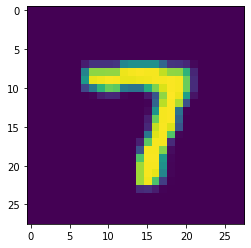

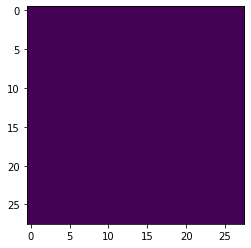

In [27]:
gen = TestImgGenSequence(1)
x,y = gen.gen_test_data(2)
print(x[0].shape)
plt.imshow(x[0])
plt.show()
plt.imshow(x[1])
img1, img2 = x

(28, 28, 1)


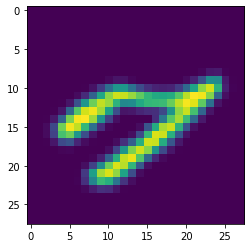

In [13]:
fimg = img2.reshape(28, 28,1)
dgen = tf.keras.preprocessing.image.ImageDataGenerator()
iim = dgen.apply_transform(fimg, {'shear':1, 'zx':1.2, 'zy':0.9})
print(iim.shape)
plt.imshow(iim)

In [14]:
act = 'relu'
pad = 'same'
strd = 1
input_layer = tf.keras.Input(shape = (OUTER_IMG_SZ, OUTER_IMG_SZ,1))
_ = tf.keras.layers.Conv2D(filters=10, kernel_size=3, activation = act, padding = pad, strides=1)(input_layer)
_ = tf.keras.layers.Conv2D(filters=10*2, kernel_size=3, activation = act, padding = pad, strides=strd)(_) 
_ = tf.keras.layers.MaxPool2D()(_)
_ = tf.keras.layers.Conv2D(filters=10*3, kernel_size=3, activation = act, padding = pad, strides = strd)(_) 
_ = tf.keras.layers.Conv2D(filters=10*4, kernel_size=3, activation = act, padding = pad, strides = strd)(_) 
_ = tf.keras.layers.MaxPool2D()(_)
_ = tf.keras.layers.Conv2D(filters=10*4, kernel_size=3, activation = act, padding = pad, strides = strd)(_) 
_ = tf.keras.layers.Conv2D(filters=10*5, kernel_size=3, activation = act, padding = pad, strides = strd)(_) 
_ = tf.keras.layers.MaxPool2D()(_) 
common_layer = tf.keras.layers.Flatten()(_)

output_layer = tf.keras.layers.Dense(10, activation = 'softmax', name="output_digit")(common_layer)

model = tf.keras.Model(inputs=input_layer, outputs = output_layer, name="digit_recognizer")
model.compile(optimizer=tf.keras.optimizers.Adamax(),
             loss = tf.keras.losses.CategoricalCrossentropy(),
             metrics = 'accuracy')
model.summary()

Model: "digit_recognizer"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 10)        100       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 20)        1820      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 20)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 30)        5430      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 40)        10840     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 40)     

In [5]:
training_gen = TestImgGenSequence(TRAIN_SIZE)
validation_gen = TestImgGenSequence(TEST_SIZE)

In [17]:
%%time

model.fit(x = training_gen, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1)

Epoch 1/10
3125/3125 [==============================] - 14s 4ms/step - loss: 0.6475 - accuracy: 0.7921
Epoch 2/10
3125/3125 [==============================] - 14s 5ms/step - loss: 0.1309 - accuracy: 0.9580
Epoch 3/10
3125/3125 [==============================] - 14s 4ms/step - loss: 0.0825 - accuracy: 0.9746
Epoch 4/10
3125/3125 [==============================] - 16s 5ms/step - loss: 0.0679 - accuracy: 0.9773
Epoch 5/10
3125/3125 [==============================] - 14s 5ms/step - loss: 0.0604 - accuracy: 0.9804
Epoch 6/10
3125/3125 [==============================] - 14s 5ms/step - loss: 0.0514 - accuracy: 0.9835
Epoch 7/10
3125/3125 [==============================] - 14s 5ms/step - loss: 0.0474 - accuracy: 0.9853
Epoch 8/10
3125/3125 [==============================] - 14s 5ms/step - loss: 0.0414 - accuracy: 0.9876
Epoch 9/10
3125/3125 [==============================] - 14s 4ms/step - loss: 0.0342 - accuracy: 0.9892
Epoch 10/10
3125/3125 [==============================] - 14s 5ms/step - l

In [18]:
model.evaluate(x=TestImgGenSequence(TEST_SIZE), y=None)

625/625 [==============================] - 1s 1ms/step - loss: 0.0263 - accuracy: 0.9919


[0.026313146576285362, 0.9919000267982483]

In [19]:
model.save('models/mnist_model')

/opt/homebrew/Caskroom/miniforge/base/envs/p38TF/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '
/opt/homebrew/Caskroom/miniforge/base/envs/p38TF/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer.py:1397: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`layer.updates` will be removed in a future version. '



FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.
INFO:tensorflow:Assets written to: models/mnist_model/assets


In [6]:
model.layers[5].get_weights()

NameError: name 'model' is not defined

In [7]:
nmdl = tf.keras.models.load_model('models/mnist_model')
nmdl.evaluate(x=TestImgGenSequence(TEST_SIZE), y=None)

625/625 [==============================] - 1s 2ms/step - loss: 0.0308 - accuracy: 0.9920


[0.030775681138038635, 0.9919999837875366]

In [22]:
nmdl.layers[5].get_weights()

[array([[[[-0.15246077,  0.07684723,  0.02973115, ..., -0.21086538,
            0.08359913, -0.02788634],
          [-0.05614688,  0.0479369 ,  0.01762312, ...,  0.06720082,
            0.07672588, -0.07129734],
          [ 0.04914112, -0.01685917, -0.06210468, ..., -0.07334051,
           -0.03147487,  0.09288959],
          ...,
          [ 0.05702347, -0.10481242,  0.00886022, ..., -0.1280659 ,
            0.01700035,  0.03856556],
          [ 0.00617778,  0.01073342, -0.09746637, ...,  0.09348628,
            0.04778268, -0.02879914],
          [-0.04038062, -0.07092635,  0.01105105, ...,  0.11993033,
           -0.00068764,  0.06343146]],
 
         [[-0.03988907, -0.1090641 , -0.00802271, ..., -0.14249445,
           -0.01459963,  0.05854427],
          [-0.13074899, -0.12184688, -0.08272532, ...,  0.11381707,
           -0.0101894 , -0.09837726],
          [ 0.0368669 , -0.06479507,  0.00070362, ..., -0.07222161,
           -0.07670929, -0.02053125],
          ...,
          [ 0

In [29]:
nmdl.evaluate(x=TestImgGenSequence(TEST_SIZE), y=None)

625/625 [==============================] - 1s 2ms/step - loss: 0.0262 - accuracy: 0.9915


[0.026194952428340912, 0.9915000200271606]